### K-means

1. Load dataframe of Seattle listings and extract lemmatized host descriptions
2. Vectorize lemmatized host descriptions
3. Extract features with SVD
4. Cluster using kmeans
5. Assign each listing a cluster
6. Pickle dataframe

In [1]:
import pickle

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline

#### Load Seattle listings dataframe and extract lemmatized host descriptions

In [2]:
with open('data/s_listings.pkl', 'rb') as picklefile:
    s_listings = pickle.load(picklefile)

In [3]:
host_lemmas = s_listings['host_lemmas']

#### Create TFIDF vector of lemmatized host descriptions
In an attempt to only include meaninful words:
* Minimum document frequency set to 10: given word must appear in at least 10 host descriptions
* Token pattern returns words with 2 or more letters
* Only unigrams (default settings of ngram_range)

In [4]:
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        min_df=10,
                        token_pattern="\\b[a-z][a-z]+\\b")
tfidf.fit(host_lemmas)
x = tfidf.transform(host_lemmas)

In [5]:
#words in tfidf vector
features = tfidf.get_feature_names()
print len(features)

1178


In [6]:
#10 words with highest tfidf
top = tfidf.idf_.argsort()[:10].tolist()
[(features[i], tfidf.idf_[i]) for i in top]

[(u'make', 2.8323329856752215),
 (u'family', 2.9131523924169302),
 (u'food', 2.9720949280503803),
 (u'get', 3.0695502642010934),
 (u'hike', 3.0894316347549222),
 (u'experience', 3.1304209792881195),
 (u'look', 3.1388243900844985),
 (u'explore', 3.19523847936459),
 (u'friend', 3.1997127597595112),
 (u'music', 3.2087218297018771)]

In [7]:
#10 words with lowest tfidf
bottom = tfidf.idf_.argsort()[::-1].tolist()[:10]
[(features[i], tfidf.idf_[i]) for i in bottom]

[(u'fun thing', 6.2089892584212594),
 (u'map', 6.2089892584212594),
 (u'take pride', 6.2089892584212594),
 (u'draw', 6.2089892584212594),
 (u'eager', 6.2089892584212594),
 (u'ease', 6.2089892584212594),
 (u'embrace', 6.2089892584212594),
 (u'ensure', 6.2089892584212594),
 (u'many wonderful', 6.2089892584212594),
 (u'develop', 6.2089892584212594)]

#### Extract features with SVD

In [8]:
svd = TruncatedSVD(n_components=650,
                   random_state=16)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [9]:
x_svd = lsa.fit_transform(x)

In [10]:
sum(svd.explained_variance_ratio_)

0.91046837563743943

As it takes 600 features (of my original 1063) to explain 90% of the variance in my data, I'll just use the original set to preserve interpretability when clustering using kmeans.

Also, this implies that my data does not have a strong structure that can be explained in a handful of components

#### Cluster using kmeans

In [11]:
k=12
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=16)
kmeans.fit(x)
clusters = kmeans.labels_.tolist()

#### Interpretation
* Show top 5 words (features in each cluster centroid with highest TFIDF)
* Show host closest to centroid of cluster (either smallest pairwise cosine distance or largest pairwise cosine similarity between host and cluster centroid)

In [12]:
#"coordinates" of cluster centers (tfidf vectors)
centroids = kmeans.cluster_centers_

#indexes of features in descending order by tfidf value
ordered_centroids = centroids.argsort()[:, ::-1]

#hosts closest to centroids by either:
#1. smallest pairwise cosine distance
#center_hosts = pd.DataFrame(pairwise_distances(x, centroids, metric='cosine')).idxmin().tolist()
#2. largest pairwise cosine similarity
center_hosts = pd.DataFrame(cosine_similarity(x, centroids)).idxmax().tolist()

In [13]:
#number of words to print
n=5

for i in range(k):
    print 'Cluster %d' % i
    print 'TOP %d WORDS:' % n
    for index in ordered_centroids[i, :n]:
        print features[index]
    print 'REPRESENTATIVE HOST:'
    print s_listings['abouts'].iloc[center_hosts[i]]
    print

Cluster 0
TOP 5 WORDS:
traveler
avid
photographer
avid traveler
fellow traveler
REPRESENTATIVE HOST:
i am a world traveler who loves an adventure and meeting new people.

Cluster 1
TOP 5 WORDS:
family
house
friend
son
name
REPRESENTATIVE HOST:
we are a family of four from seattle.

Cluster 2
TOP 5 WORDS:
music
art
food
hike
play
REPRESENTATIVE HOST:
i love to travel, garden, backpack, play and listen to music. 

i work in the theatre arts making costumes. it's great to be creative in my work. 

i like to read and relax on the patio in the evening, but also go out and explore nature by day and music, dance by night. 

Cluster 3
TOP 5 WORDS:
husband
hike
outdoors
explore
wife
REPRESENTATIVE HOST:
originally from chicago, i have adapted to my last ten years in seattle by exploring the many neighborhoods the city has to offer and getting out of the city for hiking whenever possible.  my chihuahua annabelle is usually by my side, and is very good at finding sun spots whenever they appear (t

#### Assign clusters to each listing

In [14]:
clusters = kmeans.labels_

In [15]:
s_listings['kmeans'] = clusters

In [16]:
s_listings['kmeans'].value_counts(sort=False)

0     106
1     221
2     176
3     621
4     136
5      63
6      40
7     327
8      58
9      65
10     99
11     99
Name: kmeans, dtype: int64

#### Pickle dataframe

In [17]:
km = s_listings['kmeans']

In [18]:
with open('data/kmeans.pkl', 'wb') as picklefile:
    pickle.dump(km, picklefile)

#### Check inertia and silhouette score for various numbers of clusters (just for kicks)

In [19]:
inertias = {}
silhouettes = {}
for k in range(2,20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=16)
    data_clustered = kmeans.fit_transform(x)
    clusters = kmeans.labels_.tolist()
    inertias[k] = kmeans.inertia_
    silhouettes[k] = silhouette_score(data_clustered, clusters, random_state=16)

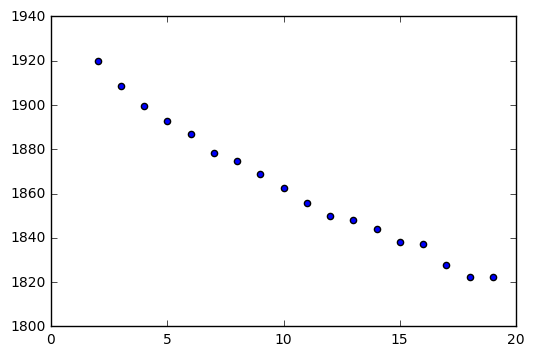

In [20]:
plt.scatter(inertias.keys(), inertias.values());

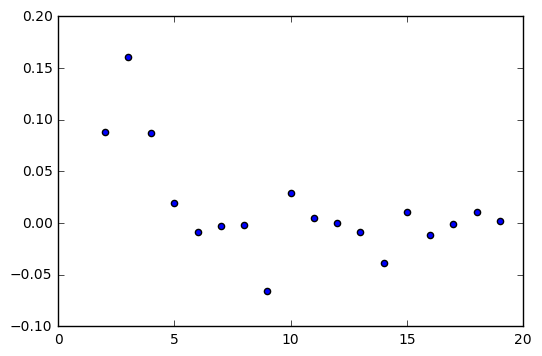

In [21]:
plt.scatter(silhouettes.keys(), silhouettes.values());

Low, erratic scores: not good, but not surprising given my data.